In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import warnings
# warnings.filterwarnings("ignore")

In [3]:
import pandas as pd 
import numpy as np
from backtest.dataframe import TradeSession, PMPandas
from backtest.base_api import event_generator

# 信号处理

## 因子值

In [4]:
#用于回测的单因子
fct=pd.read_pickle("./data/factor.pickle") #单因子值,格式为有name的pd.series
fct.dropna().tail()

date      windcode 
20230427  128140.SZ    18.829575
          128141.SZ     4.113737
          128142.SZ     4.907253
          128143.SZ    10.290646
          128144.SZ     5.070907
Name: 因子值, dtype: float64

In [5]:
fct = fct.dropna().reset_index()
fct['date'] = pd.to_datetime(fct['date'])
fct.columns = ['date', 'code', 'value']

In [6]:
fct.tail()

,date,code,value
401435,2023-04-27,128140.SZ,18.829575
401436,2023-04-27,128141.SZ,4.113737
401437,2023-04-27,128142.SZ,4.907253
401438,2023-04-27,128143.SZ,10.290646
401439,2023-04-27,128144.SZ,5.070907


<Axes: >

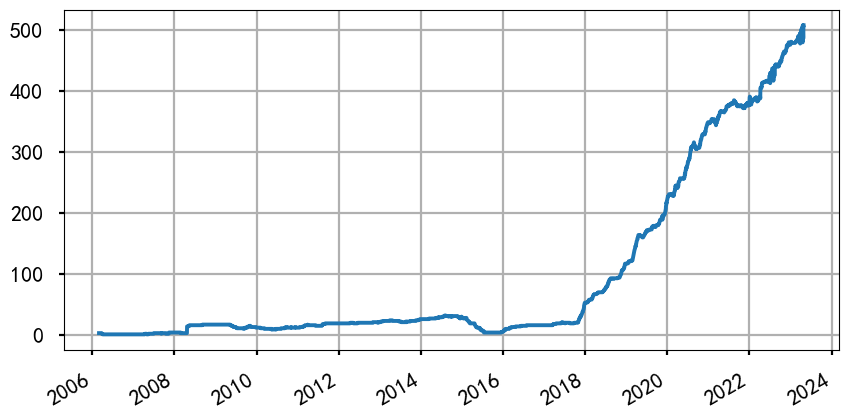

In [7]:
fct['date'].value_counts().sort_index().plot(figsize=(10, 5), grid=True)

<Axes: xlabel='date'>

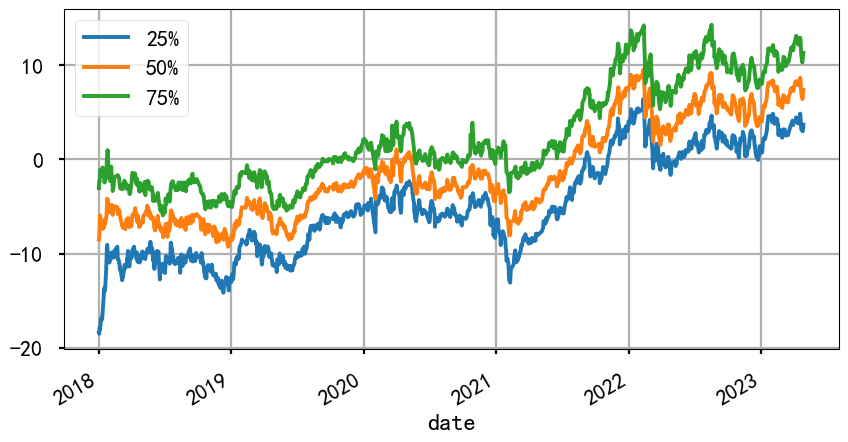

In [8]:
fct.groupby('date')['value'].describe().loc[
    '2018':,['25%', '50%', '75%']].plot(
    figsize=(10, 5), grid=True)

## 指数

In [9]:
index = pd.read_pickle("./data/zzeq.pickle")
index.tail()

date
20230421    2.133467
20230424    2.117063
20230425    2.105373
20230426    2.124780
20230427    2.133337
Name: 转债等权指数, dtype: float64

In [10]:
index.isnull().sum()

0

<Axes: xlabel='date'>

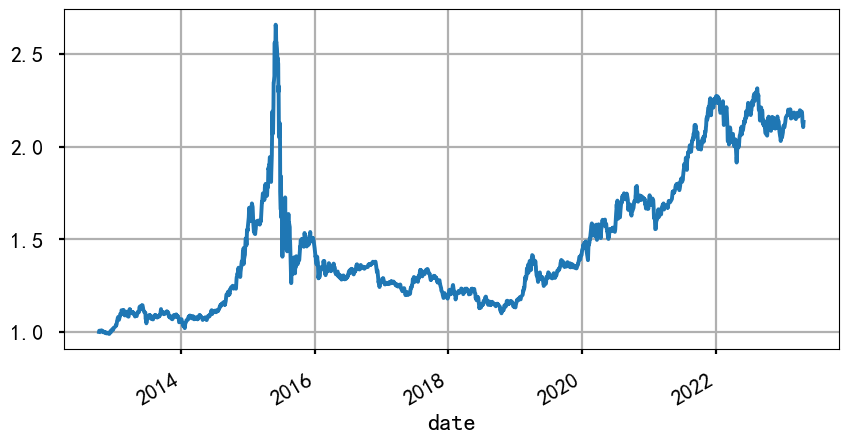

In [11]:
index.index = pd.to_datetime(index.index)
index.plot(figsize=(10, 5), grid=True)

## not_include

In [12]:
# not_include
not_include = pd.DataFrame(pd.read_pickle('./data/nil.pickle'),
    columns=['date', 'code'])
not_include['date'] = pd.to_datetime(not_include['date'])

not_include.head()

,date,code
0,2017-12-29,113502.SH
1,2018-01-02,113502.SH
2,2018-01-03,113502.SH
3,2018-01-04,113502.SH
4,2018-01-05,113502.SH


# 回测

## 初始化

In [13]:
ts = TradeSession(PMPandas, cash=1e8,
                  start_datetime='2017-12-28', end_datetime='2023-05-01',)
date_weekend = pd.date_range(start='2017', end='2024', freq='w')
events_weekend = event_generator(date_weekend.to_pydatetime(), 'week_end', event_seq=5)
ts.add_events(events_weekend)

In [14]:
ts_events = pd.DataFrame(ts.events)
ts_events['event_type'].value_counts()

EventType.OPEN       2754
EventType.CLOSE      2754
EventType.RECORD     1295
EventType.WEEKEND     366
Name: event_type, dtype: int64

In [15]:
ts_events['event_type']= ts_events['event_type'].apply(lambda x:x.value)
ts_events.groupby('event_type')['datetime'].agg(['min', 'max'])

,min,max
event_type,,
close,2012-01-04 15:00:00,2023-05-08 15:00:00
open,2012-01-04 09:30:00,2023-05-08 09:30:00
record,2017-12-28 20:00:00,2023-04-28 20:00:00
week_end,2017-01-01 00:00:00,2023-12-31 00:00:00


In [16]:
# 每次回测前会根据时间把多余的事件过滤掉
backtest_events = ts.get_event_dict() 
cal_temp = []
for t in sorted(backtest_events.keys()):
    for event in backtest_events[t]:
        cal_temp += [[t, event.event_type.value]]
pd.DataFrame(cal_temp,
             columns=['datetime', 'event_type'
                      ]).groupby('event_type')['datetime'].agg(['min', 'max'])

,min,max
event_type,,
close,2017-12-28 15:00:00,2023-04-28 15:00:00
open,2017-12-28 09:30:00,2023-04-28 09:30:00
record,2017-12-28 20:00:00,2023-04-28 20:00:00
week_end,2017-12-31 00:00:00,2023-04-30 00:00:00


## 简单的定期选股回测

1. 回测时间段为20171229至今，策略净值的起始日为20180102，20171229的数据仅用于观察因子值排名、并确定20180102的持仓名单，严格意义上的回测是20180102至今；


2. 调仓周期为周度，假设W1、W2为连续两个自然周，W1的最后一个交易日观察因子排名，【按fct中的因子值排名后20%得到W2的转债持仓list(等权持有)】，并于W2的第一个交易日开盘进行调仓与再平衡（买入在list中但未持有的转债、卖出不在list中但正持有的转债，对在list中且正持有的转债进行再平衡）；


3. 成交顺序为先卖出再买入（确保有足够多的现金）；


4. W1第一个交易日收盘时，观察实际成交的情况，可考虑将交易划分为三类：建仓、清仓、再平衡（如下图）：

    1） 对于清仓的转债，若存在未卖完的部分，第二个、第三个、第四个交易日继续卖，直到卖完为止； 若到W1的最后一个交易日收盘仍未卖完，则根据W1最后一个交易日因子值给出得list建议进行操作，若不在list中，则在W2中继续卖；若在list中，则撤出剩余的卖单，根据list建议在W2中进行买入
    
    2） 对于建仓及再平衡的转债，若剩余未成交金额<=15w，则撤单不再买入，否则在第二个、第三个、第四个交易日继续交易，直到交易完成或者本周最后一个交易日，按照更新后的持仓list进行操作
    
    
5. 回测2中情形，1）没有成交额限制（个券成交额不高于当日实际成交额的100%）；2）有成交额限制（不高于当日实际成交额的10%）


6. 交易成本的假设：按vwap成交的情况下，无需考虑冲击成本？ or 冲击成本单边1‰


7. 返回内容：策略净值、持仓/调仓记录、策略换手情况

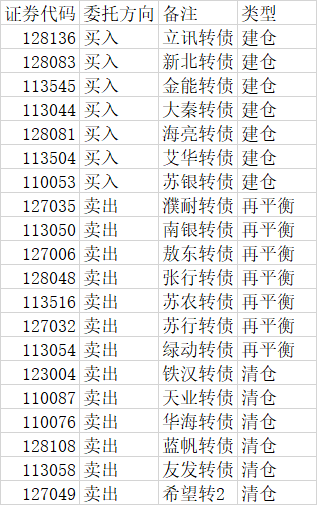

In [17]:
class PMSimple(PMPandas):
    def init(self):
        mkt = self.get_mkt_obj()
        mkt.buy_fee_ratio = 5e-4 + 5e-4  # 佣金与冲击成本
        mkt.sell_fee_ratio = 5e-4 + 5e-4 + 1e-3  # 佣金与冲击成本与印花税
        mkt.vwap_volume_limit_ratio = 0.05  # 成交量占当日的成交量上限
        self.week_count = 0  # 用于打印回测进度
        self.add_factor()
        self.send_record = pd.DataFrame()

    def after_close(self):
        # 如果成交量小于1手则取消订单
        active_orders = self.active_orders
        l_long = active_orders['targetVol'] > active_orders['filledVol']
        l_amount = active_orders['targetVol'] - active_orders['filledVol'] < 10 # 一手的量 
        self.cancel_orders(active_orders.loc[l_amount & l_long])

    def after_week_end(self):
        # 打印日志
        self.week_count += 1
        if self.week_count % 20 == 0:
            print(self.observer.time, self.balance['netAsset'])
            
        # 每周末， 取消所有的活跃订单(0号和1号订单代表不会被取消的订单)
        self.cancel_orders(self.active_orders)
        
        # 计算买单
        # 计算标的之间的相对持仓比例， 如果是等权持仓随便传入一个正数即可
        self.select_secu_tobuy()
        self.order_data['ratio_relative'] = 7.5
        
        self.send_record = pd.concat((self.send_record, self.order_data))

        # 发送订单
        # target_ratio_VWAP 会根据输入的ratio_relative（标的相对的权重）与ratio_to_netasset（总的买入资金占净资产的比例）
        # 订单策略会根据输入的比例，自动计算目标仓位，并结合当前的持仓进行开、平操作，避免额外的费用
        # 注意，因为发送订单的时候并不知道未来价格波动以及订单是否会被成交，因此给出的结果是近似结果
        self.send_orders(
            self.order_data,  # 订单的信息， 需要的字段由 order_type决定， 大部分情况下包含 code，ratio_relative两列 或 code， targetVol两列组合
            order_type='target_ratio_vwap',  # 订单算法详见 cb_daily.CBTargetRatioVWAP
            ratio_to_netasset=1,  # 买入的金额占组合净资产的比例， 如果是1则表示满仓买入
            order_seq_short=5,  # 卖单的交易顺序
            order_seq_long=10)  # 买单的交易顺序
        
    def add_factor(self):
        "初始化的时候把不复合条件的标的删除"
        res = pd.merge(fct, not_include, on=['date', 'code'], how='outer', indicator=True)
        l = res['_merge'] == 'left_only'
        self.fct = res.loc[l]
        del self.fct['_merge']
    
    def select_secu_tobuy(self):
        # 选择要持仓的股票
        mkt = self.get_mkt_obj()
        fct_temp = self.get_last_fct()
        l_top20 = fct_temp['value'] < fct_temp['value'].quantile(0.2)  # 小于20%
        l_valide = fct_temp['code'].isin(
            mkt.current_frame.index)  # 有些股票有因子值但是没有行情信息
        self.order_data = fct_temp.loc[l_top20 & l_valide].copy()

    def get_last_fct(self):
        # 获取最新交易日对应的因子值
        # 注意， 这种方法获取的因子值只能收盘后使用（xx日开盘的时候因子值很可能尚未计算出来）
        mkt = self.get_mkt_obj()
        last_trade_date = mkt.trade_date
        return (self.fct.query("date ==@last_trade_date"))

In [18]:
# 回测，加载策略，运行回测
ts.PortfolioManager = PMSimple
obs = ts.run()

2018-05-13 00:00:00 109152381.18230641
2018-09-30 00:00:00 103263954.0257929
2019-02-17 00:00:00 112909081.54068473
2019-07-07 00:00:00 140772778.48384094
2019-11-24 00:00:00 146243364.03417152
2020-04-12 00:00:00 184290212.31322986
2020-08-30 00:00:00 217767873.13452214
2021-01-17 00:00:00 212197749.11247832
2021-06-06 00:00:00 244237836.3706391
2021-10-24 00:00:00 274241170.21219456
2022-03-13 00:00:00 294175577.0560278
2022-07-31 00:00:00 315066850.6931498
2022-12-18 00:00:00 303059512.0859965


### 结果

#### 组合现状

In [19]:
obs.position

,orderID,tradeID,secuType,code,transTime,transPrice,settlePrice,volume,frozenVol
0,17557,23983,cb_daily,110072.SH,2020-12-21 15:00:00,87.548372,92.8315,37009.277567,37009.277567
1,17689,24222,cb_daily,128100.SZ,2020-12-28 15:00:00,88.890476,70.2027,38534.581281,38534.581281
2,19313,26753,cb_daily,110064.SH,2021-03-15 15:00:00,96.862318,116.4087,4743.001473,4743.001473
3,19313,26847,cb_daily,110064.SH,2021-03-16 15:00:00,97.304041,116.4087,3373.707074,3373.707074
4,19313,26931,cb_daily,110064.SH,2021-03-17 15:00:00,97.601041,116.4087,4545.000000,4545.000000
...,...,...,...,...,...,...,...,...,...
652,39702,56685,cb_daily,128083.SZ,2023-04-27 15:00:00,125.813849,127.5469,43.110906,43.110906
653,39703,56686,cb_daily,128087.SZ,2023-04-27 15:00:00,119.683872,120.9514,529.350166,529.350166
654,39704,56687,cb_daily,128141.SZ,2023-04-27 15:00:00,124.695148,125.6156,418.627165,418.627165
655,39691,56692,cb_daily,113549.SH,2023-04-28 15:00:00,115.120341,115.0469,8286.152178,8286.152178


##### 持仓中由很多持仓很久的仓位

1. 仓位按标的聚合后数量就少了
2. 持仓中最早出现的股票一直处于买入列表中

In [20]:
obs.position_records_

,recordTime,orderID,tradeID,secuType,code,transTime,transPrice,settlePrice,volume,frozenVol
0,2018-01-02 20:00:00,0,0,cb_daily,110039.SH,2018-01-02 15:00:00,106.939570,107.1314,9204.000000,-0.0
1,2018-01-03 20:00:00,0,0,cb_daily,110039.SH,2018-01-02 15:00:00,106.939570,107.9605,9204.000000,-0.0
2,2018-01-03 20:00:00,0,1,cb_daily,110039.SH,2018-01-03 15:00:00,107.955941,107.9605,11331.000000,-0.0
3,2018-01-04 20:00:00,0,0,cb_daily,110039.SH,2018-01-02 15:00:00,106.939570,110.3097,9204.000000,-0.0
4,2018-01-04 20:00:00,0,1,cb_daily,110039.SH,2018-01-03 15:00:00,107.955941,110.3097,11331.000000,-0.0
...,...,...,...,...,...,...,...,...,...,...
443287,2023-04-28 20:00:00,39702,56685,cb_daily,128083.SZ,2023-04-27 15:00:00,125.813849,127.5469,43.110906,-0.0
443288,2023-04-28 20:00:00,39703,56686,cb_daily,128087.SZ,2023-04-27 15:00:00,119.683872,120.9514,529.350166,-0.0
443289,2023-04-28 20:00:00,39704,56687,cb_daily,128141.SZ,2023-04-27 15:00:00,124.695148,125.6156,418.627165,-0.0
443290,2023-04-28 20:00:00,39691,56692,cb_daily,113549.SH,2023-04-28 15:00:00,115.120341,115.0469,8286.152178,-0.0


<Axes: >

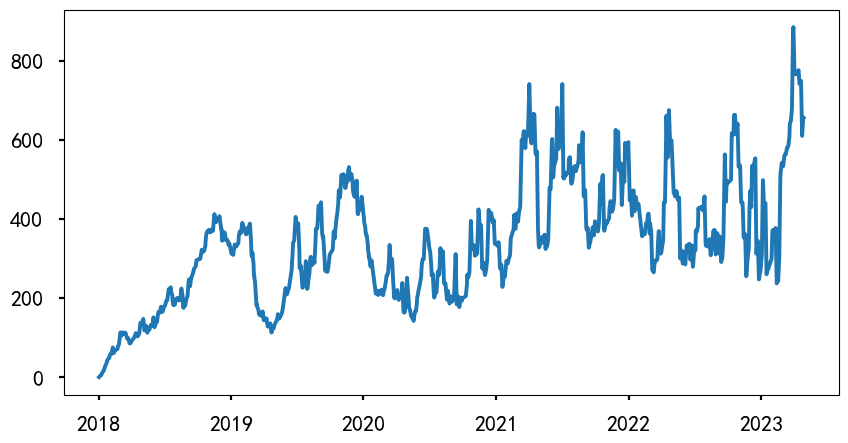

In [21]:
obs.position_records['date'] = obs.position_records['date']
obs.position_records['date'].value_counts().sort_index().plot(figsize=(10,5))

<Axes: >

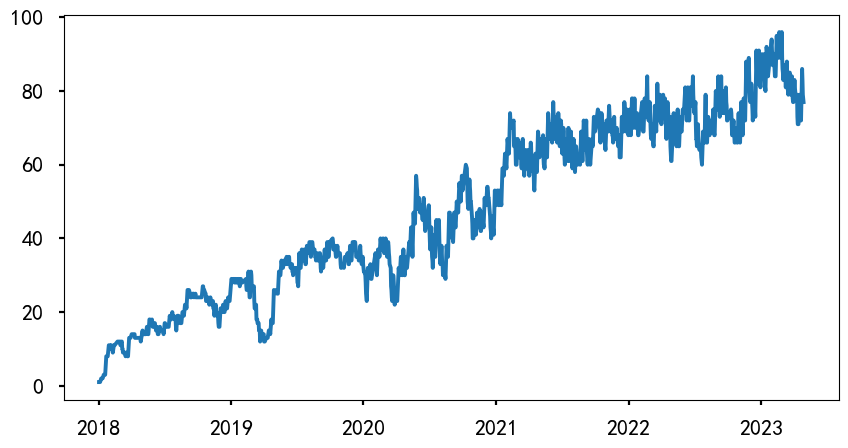

In [22]:
obs.position_records.groupby(['code', 'date'], as_index=False)[
    'volume'].sum()['date'].value_counts().sort_index().plot(figsize=(10,5))

In [23]:
obs.position.sort_values('transTime').head()

,orderID,tradeID,secuType,code,transTime,transPrice,settlePrice,volume,frozenVol
0,17557,23983,cb_daily,110072.SH,2020-12-21 15:00:00,87.548372,92.8315,37009.277567,37009.277567
1,17689,24222,cb_daily,128100.SZ,2020-12-28 15:00:00,88.890476,70.2027,38534.581281,38534.581281
2,19313,26753,cb_daily,110064.SH,2021-03-15 15:00:00,96.862318,116.4087,4743.001473,4743.001473
3,19313,26847,cb_daily,110064.SH,2021-03-16 15:00:00,97.304041,116.4087,3373.707074,3373.707074
4,19313,26931,cb_daily,110064.SH,2021-03-17 15:00:00,97.601041,116.4087,4545.000000,4545.000000


In [24]:
res = pd.pivot(ts.pm.send_record.drop_duplicates(subset=['code', 'date']), 
               columns='code', index='date', values='value')
res.tail()

code,110034.SH,110038.SH,110039.SH,110041.SH,110043.SH,110044.SH,110045.SH,110046.SH,110047.SH,110049.SH,...,128133.SZ,128134.SZ,128138.SZ,128139.SZ,128140.SZ,128141.SZ,128142.SZ,128143.SZ,128144.SZ,128145.SZ
date,,,,,,,,,,,,,,,,,,,,,
2023-03-24,NaN,NaN,NaN,NaN,1.493133,NaN,NaN,NaN,0.990289,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-31,NaN,NaN,NaN,NaN,1.602763,NaN,NaN,NaN,0.953776,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-07,NaN,NaN,NaN,NaN,2.303374,NaN,NaN,NaN,1.724138,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-14,NaN,NaN,NaN,NaN,2.415900,NaN,NaN,NaN,1.699136,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.159673,NaN,...,NaN,NaN,NaN,NaN,NaN,1.610183,NaN,NaN,NaN,NaN


In [25]:
# 判断是否自从2021年后一直处于buy列表中
(res.loc['2020-12-21':, '110072.SH'].isnull().sum() == 0,
 res.loc['2021-08-23':, '128100.SZ'].isnull().sum() == 0,
 res.loc['2021-11-01':, '127018.SZ'].isnull().sum() == 0,
 res.loc['2021-11-15':, '113021.SH'].isnull().sum() == 0,)

(True, True, True, True)

##### 净资产

In [26]:
obs.balance

{'netAsset': 311409940.1944092, 'cash': 286115.99567388394, 'frozenCash': 0}

In [27]:
obs.active_orders

,orderID,secuType,code,orderTime,orderType,direction,targetPrice,targetVol,filledVol,offsetID,status,orderSeq
0,39948,cb_daily,128141.SZ,2023-04-30,vwap,net,125.6156,-418.627165,0.0,56687,unsubmit,5
1,39949,cb_daily,128141.SZ,2023-04-30,vwap,net,125.6156,-11418.478604,0.0,56665,unsubmit,5
2,39950,cb_daily,128141.SZ,2023-04-30,vwap,net,125.6156,-12358.182431,0.0,56631,unsubmit,5
3,39951,cb_daily,128141.SZ,2023-04-30,vwap,net,125.6156,-9085.432199,0.0,56592,unsubmit,5
4,39952,cb_daily,128129.SZ,2023-04-30,vwap,net,101.0576,-215.086304,0.0,55448,unsubmit,5
...,...,...,...,...,...,...,...,...,...,...,...,...
652,40600,cb_daily,110047.SH,2023-04-30,vwap,net,116.5598,-8.312345,0.0,54303,unsubmit,5
653,40601,cb_daily,110047.SH,2023-04-30,vwap,net,116.5598,-47.084851,0.0,54213,unsubmit,5
654,40602,cb_daily,110047.SH,2023-04-30,vwap,net,116.5598,-548.621787,0.0,54120,unsubmit,5
655,40603,cb_daily,110047.SH,2023-04-30,vwap,net,116.5598,-6025.831940,0.0,49951,unsubmit,5


In [28]:
obs.active_order_params

{}

#### 交易记录

In [29]:
obs.trade_records.tail()

,tradeID,orderID,secuType,code,transTime,direction,transPrice,transVol,offsetID,transCost
56689,56689,39791,cb_daily,113516.SH,2023-04-28 15:00:00,net,113.042254,-3287.500000,53715,743.252823
56690,56690,39792,cb_daily,113516.SH,2023-04-28 15:00:00,net,113.042254,-1761.718829,52840,398.297336
56691,56691,39755,cb_daily,127044.SZ,2023-04-28 15:00:00,net,113.398434,-3975.300000,54612,901.585590
56692,56692,39691,cb_daily,113549.SH,2023-04-28 15:00:00,long,115.120341,8286.152178,-1,953.904663
56693,56693,39708,cb_daily,123049.SZ,2023-04-28 15:00:00,long,106.629644,3486.444505,-1,371.758336


#### balance记录

In [30]:
obs.balance_records.tail()

,recordTime,netAsset,cash,frozenCash,date
1290,2023-04-24 20:00:00,3.074313e+08,0.000000,2.383441e+07,2023-04-24
1291,2023-04-25 20:00:00,3.065772e+08,0.000000,9.132269e+06,2023-04-25
1292,2023-04-26 20:00:00,3.080085e+08,0.000000,2.820296e+06,2023-04-26
1293,2023-04-27 20:00:00,3.096736e+08,392900.846352,1.316909e+06,2023-04-27
1294,2023-04-28 20:00:00,3.114099e+08,286115.995674,0.000000e+00,2023-04-28


#### 持仓记录

In [31]:
obs.position_records

,recordTime,orderID,tradeID,secuType,code,transTime,transPrice,settlePrice,volume,frozenVol,date,mktv
0,2018-01-02 20:00:00,0,0,cb_daily,110039.SH,2018-01-02 15:00:00,106.939570,107.1314,9204.000000,-0.0,2018-01-02,9.860374e+05
1,2018-01-03 20:00:00,0,0,cb_daily,110039.SH,2018-01-02 15:00:00,106.939570,107.9605,9204.000000,-0.0,2018-01-03,9.936684e+05
2,2018-01-03 20:00:00,0,1,cb_daily,110039.SH,2018-01-03 15:00:00,107.955941,107.9605,11331.000000,-0.0,2018-01-03,1.223300e+06
3,2018-01-04 20:00:00,0,0,cb_daily,110039.SH,2018-01-02 15:00:00,106.939570,110.3097,9204.000000,-0.0,2018-01-04,1.015290e+06
4,2018-01-04 20:00:00,0,1,cb_daily,110039.SH,2018-01-03 15:00:00,107.955941,110.3097,11331.000000,-0.0,2018-01-04,1.249919e+06
...,...,...,...,...,...,...,...,...,...,...,...,...
443287,2023-04-28 20:00:00,39702,56685,cb_daily,128083.SZ,2023-04-27 15:00:00,125.813849,127.5469,43.110906,-0.0,2023-04-28,5.498662e+03
443288,2023-04-28 20:00:00,39703,56686,cb_daily,128087.SZ,2023-04-27 15:00:00,119.683872,120.9514,529.350166,-0.0,2023-04-28,6.402564e+04
443289,2023-04-28 20:00:00,39704,56687,cb_daily,128141.SZ,2023-04-27 15:00:00,124.695148,125.6156,418.627165,-0.0,2023-04-28,5.258610e+04
443290,2023-04-28 20:00:00,39691,56692,cb_daily,113549.SH,2023-04-28 15:00:00,115.120341,115.0469,8286.152178,-0.0,2023-04-28,9.532961e+05


### 检查

#### 持仓资产+现金等于基金净值

In [32]:
obs.check_position_net()

,netAsset,cash,position_asset,netAsset_cal
recordTime,,,,
2017-12-28 20:00:00,1.000000e+08,1.000000e+08,NaN,1.000000e+08
2017-12-29 20:00:00,1.000000e+08,1.000000e+08,NaN,1.000000e+08
2018-01-02 20:00:00,1.000008e+08,9.901474e+07,9.860374e+05,1.000008e+08
2018-01-03 20:00:00,1.000072e+08,9.779027e+07,2.216969e+06,1.000072e+08
2018-01-04 20:00:00,1.000622e+08,9.612653e+07,3.935685e+06,1.000622e+08
...,...,...,...,...
2023-04-24 20:00:00,3.074313e+08,0.000000e+00,3.074313e+08,3.074313e+08
2023-04-25 20:00:00,3.065772e+08,0.000000e+00,3.065772e+08,3.065772e+08
2023-04-26 20:00:00,3.080085e+08,0.000000e+00,3.080085e+08,3.080085e+08


#### 期初期末持仓价值变动+期间的交易的费用=期初期末净资产的变动

In [33]:
obs.check_trade_net()

{'nav_end': 311409940.1944092,
 'nav_start': 100000781.3338,
 'trade_amount': 65126020.315809794,
 'trade_cost': 33602607.61671647,
 'pv_end': 311123824.19873536,
 'pv_start': 986037.4055999999,
 'nav_end_cal': 311409940.1944091}

In [34]:
res = obs.check_trade_net()
print('手续费：', -1*res['trade_cost'] / 1e8)

手续费： -0.3360260761671647


In [35]:
print('交易贡献：', (res['pv_end'] - res['pv_start'] - res['trade_amount'])/ 1e8)

交易贡献： 2.4501176647732557


#### 期末持仓等于期初持仓+期间的交易

In [36]:
obs.check_trade_position(start_datetime='2018-01-01', end_datetime='2019-01-01')

volume_start  volume_trade    volume_end    volume_net
secuType code                                                             
cb_daily 110039.SH        9204.0 -9.204000e+03           NaN  0.000000e+00
         110041.SH           NaN -7.275958e-12           NaN -7.275958e-12
         110043.SH           NaN  2.182787e-11           NaN  2.182787e-11
         110044.SH           NaN  6.975371e+04  69753.713921  0.000000e+00
         110045.SH           NaN  7.056106e+04  70561.057187  0.000000e+00
         110046.SH           NaN  2.373804e+04  23738.042172  0.000000e+00
         110047.SH           NaN  6.214715e+04  62147.151946  0.000000e+00
         113015.SH           NaN  0.000000e+00           NaN  0.000000e+00
         113017.SH           NaN  4.547474e-13           NaN  4.547474e-13
         113503.SH           NaN  0.000000e+00           NaN  0.000000e+00
         113505.SH           NaN -9.094947e-13           NaN -9.094947e-13
         113506.SH           NaN  6.517312e+04  65173.115709  0.000000e+00
         113507.SH           NaN  0.000000e+00           NaN  0.000000e+00
         113508.SH           NaN -3.637979e-12           NaN -3.637979e-12
         113509.SH           NaN  4.596452e+04  45964.516379  0.000000e+00
         113511.SH           NaN  0.000000e+00           NaN  0.000000e+00
         113513.SH           NaN  5.482356e+04  54823.564841  0.000000e+00
         113515.SH           NaN  4.625113e+04  46251.130597  0.000000e+00
         113516.SH           NaN  3.637979e-12           NaN  3.637979e-12
         113517.SH           NaN  3.637979e-12           NaN  3.637979e-12
         113518.SH           NaN  5.730041e+04  57300.411056  0.000000e+00
         113519.SH           NaN  6.331265e+04  63312.652694  0.000000e+00
         113521.SH           NaN  1.352217e+04  13522.169842  0.000000e+00
         113522.SH           NaN  2.430265e+04  24302.649096  0.000000e+00
         123001.SZ           NaN  7.232962e+04  72329.617817  0.000000e+00
         123003.SZ           NaN -1.909939e-11           NaN -1.909939e-11
         123005.SZ           NaN  2.182787e-11           NaN  2.182787e-11
         123006.SZ           NaN  1.455192e-11           NaN  1.455192e-11
         123007.SZ           NaN -1.091394e-11           NaN -1.091394e-11
         123008.SZ           NaN  7.275958e-12           NaN  7.275958e-12
         123009.SZ           NaN  6.366463e-12           NaN  6.366463e-12
         123011.SZ           NaN  5.095494e+03   5095.493566 -9.094947e-13
         123012.SZ           NaN  1.364242e-11           NaN  1.364242e-11
         123014.SZ           NaN  5.215102e+04  52151.018634  0.000000e+00
         123015.SZ           NaN  1.866007e+04  18660.066925  0.000000e+00
         127007.SZ           NaN  0.000000e+00           NaN  0.000000e+00
         128012.SZ           NaN  1.265255e+04  12652.554410  1.818989e-12
         128018.SZ           NaN -1.364242e-12           NaN -1.364242e-12
         128019.SZ           NaN -9.094947e-13           NaN -9.094947e-13
         128021.SZ           NaN  3.846895e+04  38468.948009  0.000000e+00
         128023.SZ           NaN  4.547474e-13           NaN  4.547474e-13
         128026.SZ           NaN  2.728484e-12           NaN  2.728484e-12
         128027.SZ           NaN -4.547474e-13           NaN -4.547474e-13
         128028.SZ           NaN  0.000000e+00           NaN  0.000000e+00
         128029.SZ           NaN  0.000000e+00           NaN  0.000000e+00
         128032.SZ           NaN  8.185452e-12           NaN  8.185452e-12
         128033.SZ           NaN  0.000000e+00           NaN  0.000000e+00
         128034.SZ           NaN  0.000000e+00           NaN  0.000000e+00
         128036.SZ           NaN  0.000000e+00           NaN  0.000000e+00
         128037.SZ           NaN -2.728484e-12           NaN -2.728484e-12
         128038.SZ           NaN  7.531386e+04  75313.860097  0.000000e+00
         128039.SZ           NaN  5.456968e-1

### 分析

#### 基金指标

In [37]:
obs.pnl_analyse(freq='day', benchmark=index,  chicol=True)

,总收益率,年化收益率,年化风险,最大回撤,夏普比率,信息比率
netAsset,2.096736,0.237764,0.136826,0.146350,1.737703,1.808223
benchmark,0.807694,0.118206,0.126991,0.157759,0.930818,NaN


#### 净值

In [38]:
obs.get_pnl_net(benchmark=index, freq='day')

,netAsset,benchmark
2017-12-28,1.000000e+08,1.180143
2017-12-29,1.000000e+08,1.186481
2018-01-02,1.000008e+08,1.196686
2018-01-03,1.000072e+08,1.210064
2018-01-04,1.000622e+08,1.215429
...,...,...
2023-04-21,3.088464e+08,2.133467
2023-04-24,3.074313e+08,2.117063
2023-04-25,3.065772e+08,2.105373
2023-04-26,3.080085e+08,2.124780


#### 净值图

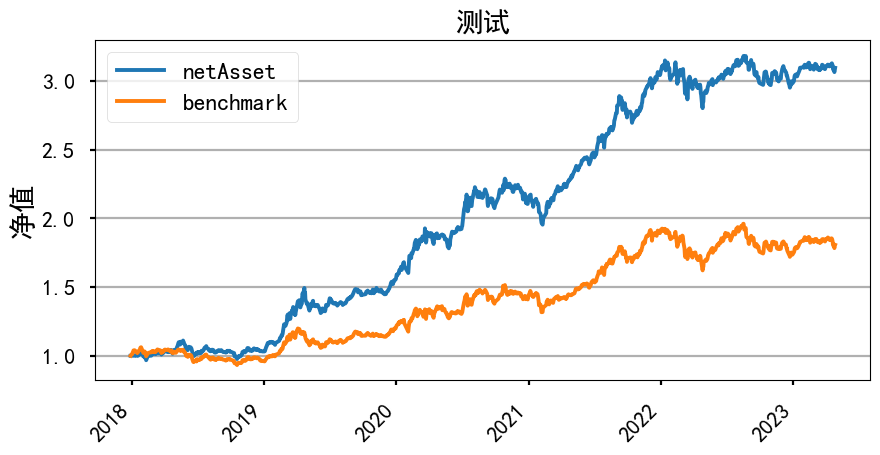

In [39]:
obs.pnl_plot(title='测试',benchmark=index, freq='day')

#### 换手率

##### 换手率 = （期间成交额+交易成本） / （期初组合净资产 + 期末组合净资产）

In [40]:
obs.cal_hsl(start_datetime='2018-01-10', end_datetime='2018-01-18', include_trade_cost=False)

{'start_record_time': Timestamp('2018-01-10 20:00:00'),
 'end_record_time': Timestamp('2018-01-17 20:00:00'),
 'nav_end': 100007789.37253001,
 'nav_start': 100199968.95473501,
 'trade_amount': 12091161.604999999,
 'trade_cost': 12091.161605,
 'hsl': 0.06039307220669969}

默认从开始到结束

In [41]:
obs.cal_hsl( include_trade_cost=False)

{'start_record_time': Timestamp('2017-12-28 20:00:00'),
 'end_record_time': Timestamp('2023-04-28 20:00:00'),
 'nav_end': 311409940.1944092,
 'nav_start': 100000000.0,
 'trade_amount': 22424431356.38284,
 'trade_cost': 33603591.88851647,
 'hsl': 54.506294490080414}

##### 周换手率


1. start_datetime 统计开始日期 周末
1. end_datetime 统计结束日期 下周末 + 2天
1. 为什么要+2天？ 
    1.  observer会根据输入的start_datetime与end_datetime自动匹配时间区间内最大和最小的recordTime
    2. recordTime默认是每个交易日结束后记录一次， 为了统计一周的换手率需要从本周一的收盘跨到下一周的收盘
    3. start_datetime = 周末，则会自动匹配周一的recordTime
    4. end_datetime = 周末加2天， 会自动匹配下周一的recordTime

In [42]:
t_start = date_weekend
t_end = date_weekend + pd.offsets.Day(7+2)
[*zip(t_start, t_end)][:5]

[(Timestamp('2017-01-01 00:00:00', freq='W-SUN'),
  Timestamp('2017-01-10 00:00:00')),
 (Timestamp('2017-01-08 00:00:00', freq='W-SUN'),
  Timestamp('2017-01-17 00:00:00')),
 (Timestamp('2017-01-15 00:00:00', freq='W-SUN'),
  Timestamp('2017-01-24 00:00:00')),
 (Timestamp('2017-01-22 00:00:00', freq='W-SUN'),
  Timestamp('2017-01-31 00:00:00')),
 (Timestamp('2017-01-29 00:00:00', freq='W-SUN'),
  Timestamp('2017-02-07 00:00:00'))]

In [43]:
hsl = obs.cal_hsl_batch(t_start, t_end, include_trade_cost=False)
hsl.tail()

,start_record_time,end_record_time,nav_end,nav_start,trade_amount,trade_cost,hsl
274,2023-03-27 20:00:00,2023-04-03 20:00:00,3.110852e+08,3.106474e+08,9.884299e+07,148338.656457,0.159218
275,2023-04-03 20:00:00,2023-04-10 20:00:00,3.113129e+08,3.110852e+08,8.995115e+07,140229.107510,0.144749
276,2023-04-10 20:00:00,2023-04-17 20:00:00,3.127543e+08,3.113129e+08,7.364217e+07,107299.340455,0.118176
277,2023-04-17 20:00:00,2023-04-24 20:00:00,3.074313e+08,3.127543e+08,1.186151e+08,175996.007264,0.191541
278,2023-04-24 20:00:00,2023-04-28 20:00:00,3.114099e+08,3.074313e+08,4.785823e+07,71966.391502,0.077452


<Axes: >

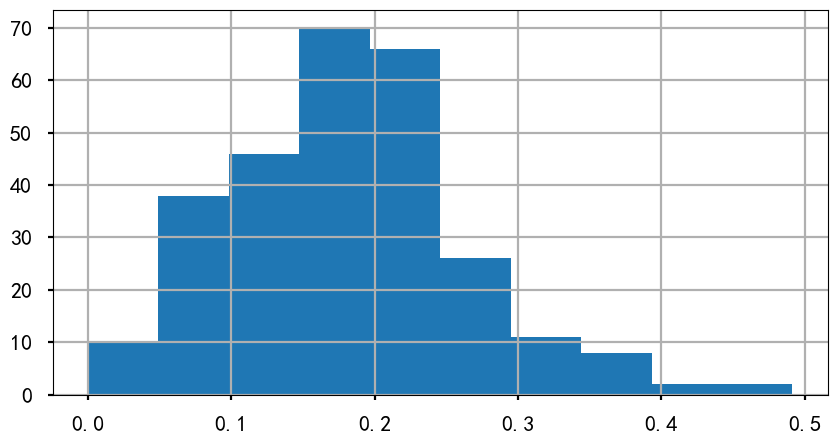

In [44]:
hsl['hsl'].hist(figsize=(10, 5))

<Axes: xlabel='end_record_time'>

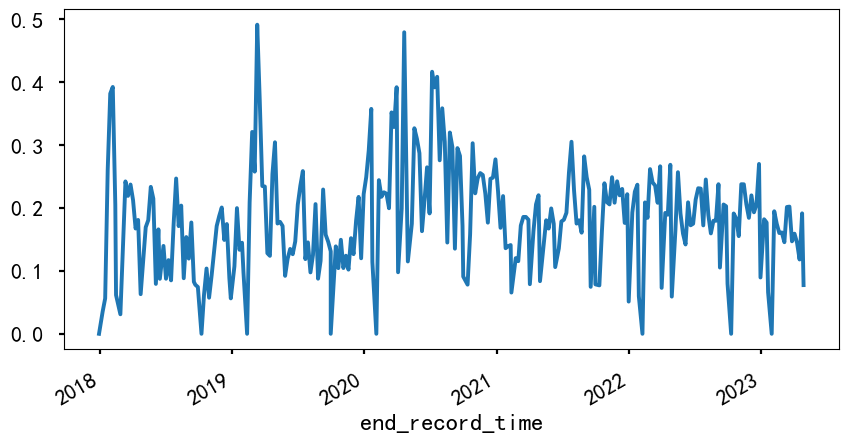

In [45]:
hsl.set_index('end_record_time')['hsl'].plot(figsize=(10, 5))

## 定期选股回测+自下而上的仓位管理

【按fct中的因子值<=0得到W2的转债持仓list(等权持有)，每期最多选30只，默认满仓，若满足条件的个券数量<30，则空出（1-N/30）的仓位】

In [46]:
class PMSimple2(PMSimple):
    def after_week_end(self):
         # 打印日志
        self.week_count += 1
        if self.week_count % 20 == 0:
            print(self.observer.time, self.balance['netAsset'])
            
        # 每周末， 取消所有的活跃订单(0号和1号订单代表不会被取消的订单)
        self.cancel_orders(self.active_orders)
        
        # 选择要持仓的股票
        mkt = self.get_mkt_obj()
        fct_temp = self.get_last_fct()
        l_positive = fct_temp['value'] < 0  # 小于0
        l_valide = fct_temp['code'].isin(
            mkt.current_frame.index)  # 有些股票有因子值但是没有行情信息
        data = fct_temp.loc[l_positive & l_valide].copy()

        # 计算标的之间的相对持仓比例， 如果是等权持仓随便传入一个正数即可
        data['ratio_relative'] = 7.5
        
        self.send_record = pd.concat((self.send_record, data))

      
        # 发送订单, 最多选30只
        if data.shape[0] > 30:
            data.sort_values('value', inplace=True, ascending=True)
            self.send_orders(
                data.head(30).copy(),  # 订单的信息， 需要的字段由 order_type决定， 大部分情况下包含 code，ratio_relative两列 或 code， targetVol两列组合
                order_type='target_ratio_vwap',  # 订单算法详见 cb_daily.CBTargetRatioVWAP
                ratio_to_netasset=1,  # 买入的金额占组合净资产的比例， 如果是1则表示满仓买入
                order_seq_short=5,  # 卖单的交易顺序
                order_seq_long=10)  # 买单的交易顺序
        else:
            self.send_orders(
                data,  # 订单的信息， 需要的字段由 order_type决定， 大部分情况下包含 code，ratio_relative两列 或 code， targetVol两列组合
                order_type='target_ratio_vwap',  # 订单算法详见 cb_daily.CBTargetRatioVWAP
                ratio_to_netasset=data.shape[0] / 30,  # 买入的金额占组合净资产的比例， 如果是1则表示满仓买入
                order_seq_short=5,  # 卖单的交易顺序
                order_seq_long=10)  # 买单的交易顺序

In [47]:
# 回测，加载策略，运行回测
ts.PortfolioManager = PMSimple2
obs = ts.run()

2018-05-13 00:00:00 105324017.74098238
2018-09-30 00:00:00 98469861.83059078
2019-02-17 00:00:00 106458717.90883587
2019-07-07 00:00:00 125793883.42827098
2019-11-24 00:00:00 130439379.88259144
2020-04-12 00:00:00 166054297.94821292
2020-08-30 00:00:00 200663503.75296825
2021-01-17 00:00:00 197915043.665251
2021-06-06 00:00:00 230719085.3142714
2021-10-24 00:00:00 262689831.14122012
2022-03-13 00:00:00 289473934.7987769
2022-07-31 00:00:00 309057295.59292877
2022-12-18 00:00:00 298210244.0498222


### 结果

#### 组合现状

In [48]:
obs.position

,orderID,tradeID,secuType,code,transTime,transPrice,settlePrice,volume,frozenVol
0,22793,32801,cb_daily,128100.SZ,2021-08-23 15:00:00,101.251509,70.2027,44067.400000,44067.400000
1,22793,32828,cb_daily,128100.SZ,2021-08-24 15:00:00,101.132697,70.2027,15823.000000,15823.000000
2,22793,32847,cb_daily,128100.SZ,2021-08-25 15:00:00,100.546513,70.2027,19316.593444,19316.593444
3,23336,33414,cb_daily,128100.SZ,2021-09-22 15:00:00,104.567930,70.2027,5230.695711,5230.695711
4,23419,33523,cb_daily,128100.SZ,2021-09-27 15:00:00,103.711374,70.2027,604.809691,604.809691
...,...,...,...,...,...,...,...,...,...
271,30546,43594,cb_daily,123096.SZ,2023-04-27 15:00:00,107.641142,108.4462,2811.150000,2811.150000
272,30548,43595,cb_daily,128062.SZ,2023-04-27 15:00:00,105.749949,106.5668,4063.701812,4063.701812
273,30542,43597,cb_daily,110064.SH,2023-04-28 15:00:00,116.055613,116.4087,9872.500000,9872.500000
274,30544,43598,cb_daily,113033.SH,2023-04-28 15:00:00,106.098026,106.0539,15006.000000,15006.000000


In [49]:
obs.position['code'].nunique()

31

In [50]:
obs.balance

{'netAsset': 296656377.4046672, 'cash': 4554857.414543111, 'frozenCash': 0}

In [51]:
obs.active_orders

,orderID,secuType,code,orderTime,orderType,direction,targetPrice,targetVol,filledVol,offsetID,status,orderSeq
0,30615,cb_daily,128129.SZ,2023-04-30,vwap,net,101.0576,-3614.663322,0.0,41590,unsubmit,5
1,30616,cb_daily,128129.SZ,2023-04-30,vwap,net,101.0576,-4390.123509,0.0,41557,unsubmit,5
2,30617,cb_daily,128129.SZ,2023-04-30,vwap,net,101.0576,-12949.471737,0.0,41521,unsubmit,5
3,30618,cb_daily,128129.SZ,2023-04-30,vwap,net,101.0576,-8913.249676,0.0,41442,unsubmit,5
4,30619,cb_daily,128129.SZ,2023-04-30,vwap,net,101.0576,-6613.729078,0.0,41426,unsubmit,5
...,...,...,...,...,...,...,...,...,...,...,...,...
271,30886,cb_daily,110057.SH,2023-04-30,vwap,net,140.5529,-70762.276135,0.0,43464,unsubmit,5
272,30887,cb_daily,110053.SH,2023-04-30,vwap,net,127.9809,-66.220920,0.0,42504,unsubmit,5
273,30888,cb_daily,110053.SH,2023-04-30,vwap,net,127.9809,-454.040403,0.0,42480,unsubmit,5
274,30889,cb_daily,110053.SH,2023-04-30,vwap,net,127.9809,-15331.406241,0.0,38726,unsubmit,5


In [52]:
obs.active_order_params

{}

#### 交易记录

In [53]:
obs.trade_records.tail()

,tradeID,orderID,secuType,code,transTime,direction,transPrice,transVol,offsetID,transCost
43595,43595,30548,cb_daily,128062.SZ,2023-04-27 15:00:00,long,105.749949,4063.701812,-1,429.736261
43596,43596,30564,cb_daily,128127.SZ,2023-04-28 15:00:00,net,108.601986,-13761.500000,36605,2989.052450
43597,43597,30542,cb_daily,110064.SH,2023-04-28 15:00:00,long,116.055613,9872.500000,-1,1145.759035
43598,43598,30544,cb_daily,113033.SH,2023-04-28 15:00:00,long,106.098026,15006.000000,-1,1592.106980
43599,43599,30546,cb_daily,123096.SZ,2023-04-28 15:00:00,long,107.806641,6315.500000,-1,680.852840


#### balance记录

In [54]:
obs.balance_records.tail()

,recordTime,netAsset,cash,frozenCash,date
1290,2023-04-24 20:00:00,2.937027e+08,1.354261e+07,2.866846e+07,2023-04-24
1291,2023-04-25 20:00:00,2.933959e+08,1.248908e+07,2.174185e+07,2023-04-25
1292,2023-04-26 20:00:00,2.935862e+08,7.443454e+06,1.531058e+07,2023-04-26
1293,2023-04-27 20:00:00,2.957629e+08,6.485458e+06,1.291315e+07,2023-04-27
1294,2023-04-28 20:00:00,2.966564e+08,4.554857e+06,9.584472e+06,2023-04-28


<Axes: xlabel='recordTime'>

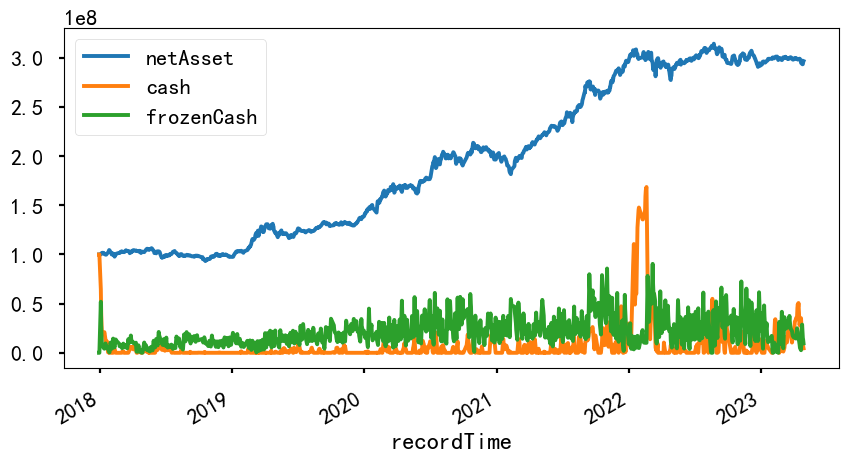

In [55]:
obs.balance_records.set_index('recordTime').plot(figsize=(10,5))

#### 持仓记录

In [56]:
obs.position_records

,recordTime,orderID,tradeID,secuType,code,transTime,transPrice,settlePrice,volume,frozenVol,date,mktv
0,2018-01-02 20:00:00,0,0,cb_daily,110032.SH,2018-01-02 15:00:00,126.488348,126.1414,27471.467074,-0.0,2018-01-02,3.465289e+06
1,2018-01-02 20:00:00,1,1,cb_daily,110033.SH,2018-01-02 15:00:00,116.973679,117.5827,9614.500000,-0.0,2018-01-02,1.130499e+06
2,2018-01-02 20:00:00,2,2,cb_daily,110034.SH,2018-01-02 15:00:00,109.211542,110.0532,10069.500000,-0.0,2018-01-02,1.108181e+06
3,2018-01-02 20:00:00,3,3,cb_daily,110038.SH,2018-01-02 15:00:00,107.198561,107.5221,3669.000000,-0.0,2018-01-02,3.944986e+05
4,2018-01-02 20:00:00,4,4,cb_daily,110039.SH,2018-01-02 15:00:00,106.939570,107.1314,9204.000000,-0.0,2018-01-02,9.860374e+05
...,...,...,...,...,...,...,...,...,...,...,...,...
454949,2023-04-28 20:00:00,30546,43594,cb_daily,123096.SZ,2023-04-27 15:00:00,107.641142,108.4462,2811.150000,-0.0,2023-04-28,3.048585e+05
454950,2023-04-28 20:00:00,30548,43595,cb_daily,128062.SZ,2023-04-27 15:00:00,105.749949,106.5668,4063.701812,-0.0,2023-04-28,4.330557e+05
454951,2023-04-28 20:00:00,30542,43597,cb_daily,110064.SH,2023-04-28 15:00:00,116.055613,116.4087,9872.500000,-0.0,2023-04-28,1.149245e+06
454952,2023-04-28 20:00:00,30544,43598,cb_daily,113033.SH,2023-04-28 15:00:00,106.098026,106.0539,15006.000000,-0.0,2023-04-28,1.591445e+06


### 检查

#### 持仓资产+现金等于基金净值

In [57]:
obs.check_position_net()

,netAsset,cash,position_asset,netAsset_cal
recordTime,,,,
2017-12-28 20:00:00,1.000000e+08,1.000000e+08,NaN,1.000000e+08
2017-12-29 20:00:00,1.000000e+08,1.000000e+08,NaN,1.000000e+08
2018-01-02 20:00:00,1.000429e+08,6.456189e+07,3.548097e+07,1.000429e+08
2018-01-03 20:00:00,1.005748e+08,4.108327e+07,5.949157e+07,1.005748e+08
2018-01-04 20:00:00,1.008997e+08,2.783183e+07,7.306790e+07,1.008997e+08
...,...,...,...,...
2023-04-24 20:00:00,2.937027e+08,1.354261e+07,2.801601e+08,2.937027e+08
2023-04-25 20:00:00,2.933959e+08,1.248908e+07,2.809068e+08,2.933959e+08
2023-04-26 20:00:00,2.935862e+08,7.443454e+06,2.861427e+08,2.935862e+08


#### 期初期末持仓价值变动+期间的交易的费用=期初期末净资产的变动

In [58]:
obs.check_trade_net()

{'nav_end': 296656377.4046672,
 'nav_start': 100042859.66130833,
 'trade_amount': 30327851.771053392,
 'trade_cost': 29679176.60854195,
 'pv_end': 292101519.99012476,
 'pv_start': 35480973.86716966,
 'nav_end_cal': 296656377.4046681}

In [59]:
res = obs.check_trade_net()
print('手续费：', -1*res['trade_cost'] / 1e8)

手续费： -0.2967917660854195


In [60]:
print('交易贡献：', (res['pv_end'] - res['pv_start'] - res['trade_amount'])/ 1e8)

交易贡献： 2.262926943519017


#### 期末持仓等于期初持仓+期间的交易

In [61]:
obs.check_trade_position(start_datetime='2018-01-01', end_datetime='2019-01-01')

volume_start  volume_trade    volume_end    volume_net
secuType code                                                             
cb_daily 110032.SH  27471.467074 -2.747147e+04           NaN  0.000000e+00
         110033.SH   9614.500000 -9.614500e+03           NaN  0.000000e+00
         110034.SH  10069.500000 -1.006950e+04           NaN  0.000000e+00
         110038.SH   3669.000000 -3.669000e+03           NaN -9.094947e-12
         110039.SH   9204.000000 -9.204000e+03           NaN  7.275958e-12
...                          ...           ...           ...           ...
         128044.SZ           NaN  0.000000e+00           NaN  0.000000e+00
         128046.SZ           NaN  5.456968e-12           NaN  5.456968e-12
         128047.SZ           NaN  1.707524e+04  17075.236492  0.000000e+00
         128048.SZ           NaN  3.250466e+04  32504.658623  0.000000e+00
         128049.SZ           NaN  1.940994e+04  19409.940226  0.000000e+00

[92 rows x 4 columns]

### 分析

#### 基金指标

In [62]:
obs.pnl_analyse(freq='day', benchmark=index,  chicol=True)

,总收益率,年化收益率,年化风险,最大回撤,夏普比率,信息比率
netAsset,1.957629,0.227075,0.134283,0.149476,1.691022,1.649752
benchmark,0.807694,0.118206,0.126991,0.157759,0.930818,NaN


#### 净值

In [63]:
obs.get_pnl_net(benchmark=index, freq='day')

,netAsset,benchmark
2017-12-28,1.000000e+08,1.180143
2017-12-29,1.000000e+08,1.186481
2018-01-02,1.000429e+08,1.196686
2018-01-03,1.005748e+08,1.210064
2018-01-04,1.008997e+08,1.215429
...,...,...
2023-04-21,2.948901e+08,2.133467
2023-04-24,2.937027e+08,2.117063
2023-04-25,2.933959e+08,2.105373
2023-04-26,2.935862e+08,2.124780


#### 净值图

##### 2022年后因子值大于0的比例很高， 详见信号处理因子值部分

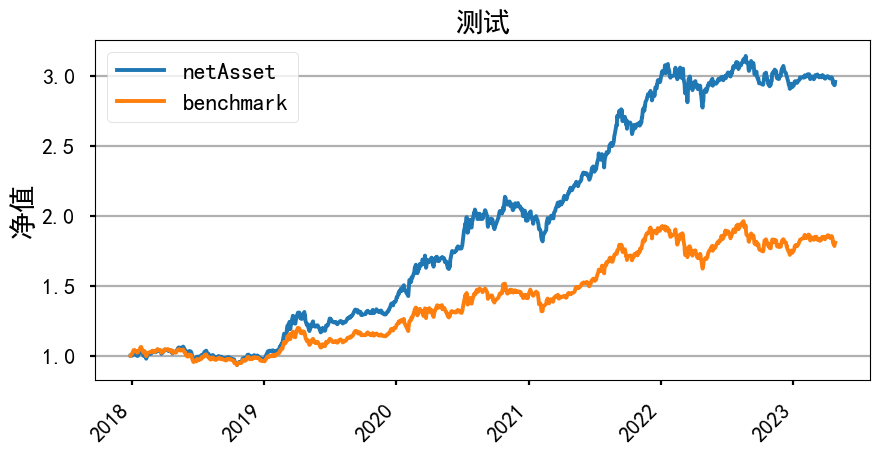

In [64]:
obs.pnl_plot(title='测试',benchmark=index, freq='day')

#### 换手率

In [65]:
obs.cal_hsl()

{'start_record_time': Timestamp('2017-12-28 20:00:00'),
 'end_record_time': Timestamp('2023-04-28 20:00:00'),
 'nav_end': 296656377.4046672,
 'nav_start': 100000000.0,
 'trade_amount': 19831629734.446087,
 'trade_cost': 29714579.320036322,
 'hsl': 50.071914748275084}

In [66]:
obs.cal_hsl_batch(t_start, t_end).tail()

,start_record_time,end_record_time,nav_end,nav_start,trade_amount,trade_cost,hsl
274,2023-03-27 20:00:00,2023-04-03 20:00:00,2.994740e+08,2.997447e+08,5.567562e+07,91959.069470,0.093067
275,2023-04-03 20:00:00,2023-04-10 20:00:00,2.987518e+08,2.994740e+08,7.395003e+07,115823.689115,0.123809
276,2023-04-10 20:00:00,2023-04-17 20:00:00,2.990890e+08,2.987518e+08,1.066471e+08,155618.166858,0.178647
277,2023-04-17 20:00:00,2023-04-24 20:00:00,2.937027e+08,2.990890e+08,7.894318e+07,111220.170504,0.133359
278,2023-04-24 20:00:00,2023-04-28 20:00:00,2.966564e+08,2.937027e+08,2.946171e+07,39718.554672,0.049972


## 定期选股回测+止盈止损事件

1. 【按fct中的因子值排名后20%得到W2的转债持仓list(等权持有)】
2. 【若持仓期间W1-W2任意一个交易日，个券累计涨幅超过10%，则于次日起清仓，未成交的买单取消】；
3. 【若持仓期间W1-W2任意一个交易日，个券累计跌幅超过5%，则于次日起清仓，未成交的买单取消】；

In [67]:
class PMSimple3(PMSimple):
    def after_close(self):
        # 取消买入量不足的订单
        super().after_close()
        # 如果成交量小于1手则取消订单

        if hasattr(self, 'is_weekend'):
            # 计算需要平仓的标的集合
            mkt = self.get_mkt_obj()
            if self.is_weekend:
                self.buy_price = mkt.current_frame['vwapAdj']
                self.is_weekend = False
            pnl = mkt.current_frame['closeAdj'] / self.buy_price - 1
            set_stop = set(pnl.index[(pnl > 0.1) | (pnl < -0.05)])

            # 取消相关活跃订单
            active_orders = self.active_orders
            l_stop = active_orders['code'].isin(set_stop)
            l_buy = active_orders['targetVol'] > active_orders['filledVol']
            self.cancel_orders(active_orders.loc[l_stop & l_buy])

            # 卖出相关的持仓
            position = self.position
            l_stop = position['code'].isin(set_stop)
            data = self.reverse_position(position.loc[l_stop].copy())
            self.send_orders(data, order_type='vwap', order_seq=5)

    def after_week_end(self):
        self.is_weekend = True
        super().after_week_end()

In [68]:
# 回测，加载策略，运行回测
ts.PortfolioManager = PMSimple3
obs = ts.run()

2018-05-13 00:00:00 109487593.20652677
2018-09-30 00:00:00 103004528.61155285
2019-02-17 00:00:00 112674325.49878775
2019-07-07 00:00:00 138034277.68909335
2019-11-24 00:00:00 143158167.5154688
2020-04-12 00:00:00 173376821.83929363
2020-08-30 00:00:00 202867787.65869787
2021-01-17 00:00:00 201608924.64296007
2021-06-06 00:00:00 233723821.33116454
2021-10-24 00:00:00 256590067.20627007
2022-03-13 00:00:00 277697779.8993569
2022-07-31 00:00:00 295281361.13695776
2022-12-18 00:00:00 285033956.11869466


### 分析

#### 基金指标

In [69]:
obs.pnl_analyse(freq='day', benchmark=index,  chicol=True)

,总收益率,年化收益率,年化风险,最大回撤,夏普比率,信息比率
netAsset,1.918524,0.223997,0.129606,0.128040,1.728287,1.678623
benchmark,0.807694,0.118206,0.126991,0.157759,0.930818,NaN


#### 净值

In [70]:
obs.get_pnl_net(benchmark=index, freq='day')

,netAsset,benchmark
2017-12-28,1.000000e+08,1.180143
2017-12-29,1.000000e+08,1.186481
2018-01-02,1.000008e+08,1.196686
2018-01-03,1.000072e+08,1.210064
2018-01-04,1.000622e+08,1.215429
...,...,...
2023-04-21,2.905994e+08,2.133467
2023-04-24,2.895375e+08,2.117063
2023-04-25,2.887007e+08,2.105373
2023-04-26,2.900115e+08,2.124780


#### 净值图

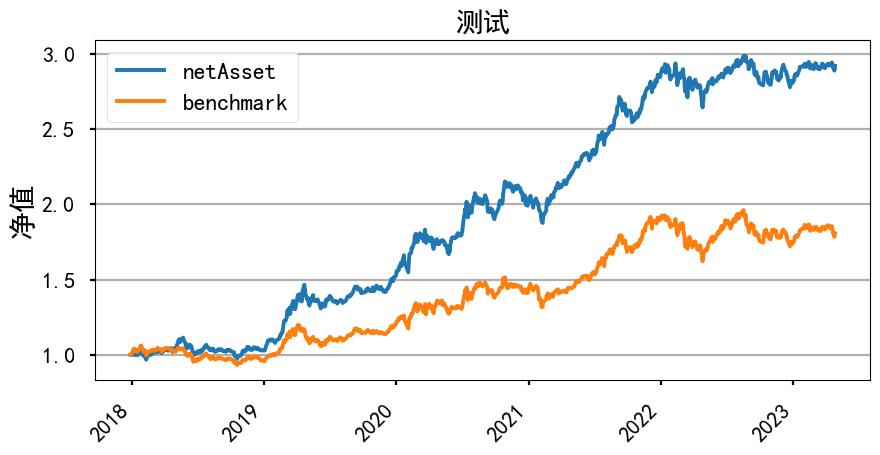

In [71]:
obs.pnl_plot(title='测试',benchmark=index, freq='day')

#### 换手率

In [72]:
obs.cal_hsl()

{'start_record_time': Timestamp('2017-12-28 20:00:00'),
 'end_record_time': Timestamp('2023-04-28 20:00:00'),
 'nav_end': 293133563.77757293,
 'nav_start': 100000000.0,
 'trade_amount': 24972634944.377598,
 'trade_cost': 37437370.97367244,
 'hsl': 63.6172400927372}

In [73]:
obs.cal_hsl_batch(t_start, t_end).tail()

,start_record_time,end_record_time,nav_end,nav_start,trade_amount,trade_cost,hsl
274,2023-03-27 20:00:00,2023-04-03 20:00:00,2.923843e+08,2.921510e+08,9.331944e+07,140049.181780,0.159887
275,2023-04-03 20:00:00,2023-04-10 20:00:00,2.926032e+08,2.923843e+08,8.495811e+07,132444.783409,0.145457
276,2023-04-10 20:00:00,2023-04-17 20:00:00,2.939673e+08,2.926032e+08,8.444314e+07,124148.919321,0.144172
277,2023-04-17 20:00:00,2023-04-24 20:00:00,2.895375e+08,2.939673e+08,1.432314e+08,212589.817097,0.245832
278,2023-04-24 20:00:00,2023-04-28 20:00:00,2.931336e+08,2.895375e+08,6.145635e+07,101935.360277,0.105648


## 定期选股回测+自下而上的仓位管理+根据因子调入调出事件

1. 【按fct中的因子值排名后20%得到W2的转债持仓list(等权持有)】
2. W1-W2之间的每个交易日，观察因子排名，若当日有N只持仓个券的排名跌出了20%（不满足入选list的条件），则于次日卖出该N只个券（取消未成交的买单单），卖出个券所腾出的仓位，由当日排名最靠前（fct因子值最低）且不在list中的N只个券填充

In [74]:
class PMSimple4(PMSimple):
    def after_close(self):
        # 先根据not_include以及买入金额小于15万的条件取消订单，卖出持仓
        super().after_close()

        # 动态调参
        if hasattr(self, 'set_buylist'):
            # 计算当前符合条件的股票
            self.select_secu_tobuy()
            self.set_buylist_now = set(self.order_data['code'])

            # 取消不在当前列表的买单
            active_orders = self.active_orders
            l_buy = active_orders['targetVol'] > active_orders['filledVol']
            l_tocancel = ~active_orders['code'].isin(self.set_buylist_now)
            self.cancel_orders(active_orders.loc[l_buy & l_tocancel])

            # 卖出不在当前列表的持仓
            l_to_net = ~self.position['code'].isin(self.set_buylist_now)
            data = self.reverse_position(self.position.loc[l_to_net].copy())
            self.send_orders(data, order_type='vwap', order_seq=5)

            # 买入新进的股票
            if len(self.set_buylist_now) > 0:
                set_tobuy = self.set_buylist_now - self.set_buylist
                data = pd.DataFrame(set_tobuy, columns=['code'])
                data['ratio_relative'] = 7.5
                self.send_orders(
                    data,  # 订单的信息， 需要的字段由 order_type决定， 大部分情况下包含 code，ratio_relative两列 或 code， targetVol两列组合
                    order_type='ratio_vwap',  # 订单算法详见 cb_daily.CBRatioVWAP
                    ratio_to_netasset=len(set_tobuy) / len(self.set_buylist_now),  # 买入的金额占组合净资产的比例， 如果是1则表示满仓买入
                    order_seq=10)

            # 更新股票列表
            self.set_buylist = self.set_buylist_now

    def after_week_end(self):
        super().after_week_end()
        self.set_buylist = set(self.order_data['code'])


class PMSimple5(PMSimple):
    "另一种实现，每次收盘后都进行再平衡"

    def after_close(self):
        self.cancel_orders(self.active_orders)

        self.select_secu_tobuy()
        # 计算标的之间的相对持仓比例， 如果是等权持仓随便传入一个正数即可
        self.order_data['ratio_relative'] = 7.5

        self.send_orders(
            self.
            order_data,  # 订单的信息， 需要的字段由 order_type决定， 大部分情况下包含 code，ratio_relative两列 或 code， targetVol两列组合
            order_type='target_ratio_vwap',  # 订单算法详见 cb_daily.CBTargetRatioVWAP
            ratio_to_netasset=1,  # 买入的金额占组合净资产的比例， 如果是1则表示满仓买入
            order_seq_short=5,  # 卖单的交易顺序
            order_seq_long=10)  # 买单的交易顺序

    def after_week_end(self):
        self.week_count += 1
        if self.week_count % 20 == 0:
            print(self.observer.time, self.balance['netAsset'])
        # 每周末， 取消所有的活跃订单(0号和1号订单代表不会被取消的订单)

In [75]:
# 回测，加载策略，运行回测
ts.PortfolioManager = PMSimple4
obs = ts.run()

2018-05-13 00:00:00 110973602.49942723
2018-09-30 00:00:00 106340141.52837795
2019-02-17 00:00:00 117753917.81869055
2019-07-07 00:00:00 142125509.02780682
2019-11-24 00:00:00 148345713.38050753
2020-04-12 00:00:00 179679964.0038326
2020-08-30 00:00:00 209983144.13450092
2021-01-17 00:00:00 213395052.83581874
2021-06-06 00:00:00 249698663.0511361
2021-10-24 00:00:00 295174995.54413795
2022-03-13 00:00:00 321175614.9676561
2022-07-31 00:00:00 343967738.07654876
2022-12-18 00:00:00 329067859.3585191


In [76]:
# 回测，加载策略，运行回测
ts.PortfolioManager = PMSimple5
obs_5 = ts.run()

2018-05-13 00:00:00 111765469.06403154
2018-09-30 00:00:00 106754660.39512609
2019-02-17 00:00:00 118422715.62281398
2019-07-07 00:00:00 144130839.98754308
2019-11-24 00:00:00 150965485.47382474
2020-04-12 00:00:00 185769873.07603016
2020-08-30 00:00:00 217116223.6626579
2021-01-17 00:00:00 220203238.73666015
2021-06-06 00:00:00 257167662.61279017
2021-10-24 00:00:00 304300008.8800042
2022-03-13 00:00:00 331990004.9730913
2022-07-31 00:00:00 356001554.31225514
2022-12-18 00:00:00 341123477.92354774


### 检查

#### 持仓资产+现金等于基金净值

In [77]:
obs.check_position_net()

,netAsset,cash,position_asset,netAsset_cal
recordTime,,,,
2017-12-28 20:00:00,1.000000e+08,1.000000e+08,NaN,1.000000e+08
2017-12-29 20:00:00,1.000000e+08,1.000000e+08,NaN,1.000000e+08
2018-01-02 20:00:00,1.000008e+08,9.901474e+07,9.860374e+05,1.000008e+08
2018-01-03 20:00:00,1.000088e+08,9.663732e+07,3.371446e+06,1.000088e+08
2018-01-04 20:00:00,1.000806e+08,9.455097e+07,5.529593e+06,1.000806e+08
...,...,...,...,...
2023-04-24 20:00:00,3.319366e+08,-7.450581e-09,3.319366e+08,3.319366e+08
2023-04-25 20:00:00,3.309524e+08,-7.450581e-09,3.309524e+08,3.309524e+08
2023-04-26 20:00:00,3.327705e+08,1.490116e-08,3.327705e+08,3.327705e+08


#### 期初期末持仓价值变动+期间的交易的费用=期初期末净资产的变动

In [78]:
obs.check_trade_net()

{'nav_end': 335806837.72451675,
 'nav_start': 100000781.3338,
 'trade_amount': 30513824.415815733,
 'trade_cost': 65668121.45175109,
 'pv_end': 332974039.6638862,
 'pv_start': 986037.4055999999,
 'nav_end_cal': 335806837.7245194}

In [79]:
res = obs.check_trade_net()
print('手续费：', -1*res['trade_cost'] / 1e8)

手续费： -0.6566812145175109


In [80]:
print('交易贡献：', (res['pv_end'] - res['pv_start'] - res['trade_amount'])/ 1e8)

交易贡献： 3.0147417784247046


#### 期末持仓等于期初持仓+期间的交易

In [81]:
obs.check_trade_position(start_datetime='2018-01-01', end_datetime='2019-01-01')

volume_start  volume_trade    volume_end    volume_net
secuType code                                                             
cb_daily 110039.SH        9204.0 -9.204000e+03           NaN -7.275958e-12
         110041.SH           NaN  0.000000e+00           NaN  0.000000e+00
         110042.SH           NaN  0.000000e+00           NaN  0.000000e+00
         110043.SH           NaN  0.000000e+00           NaN  0.000000e+00
         110044.SH           NaN  7.195131e+04  71951.312961  0.000000e+00
...                          ...           ...           ...           ...
         128044.SZ           NaN -2.273737e-13           NaN -2.273737e-13
         128046.SZ           NaN  0.000000e+00           NaN  0.000000e+00
         128048.SZ           NaN  5.456968e-12           NaN  5.456968e-12
         128049.SZ           NaN  3.678169e+04  36781.689955  0.000000e+00
         128050.SZ           NaN  5.244294e+03   5244.294007  0.000000e+00

[66 rows x 4 columns]

### 分析

#### 基金指标

In [82]:
obs.pnl_analyse(freq='day', benchmark=index,  chicol=True)

,总收益率,年化收益率,年化风险,最大回撤,夏普比率,信息比率
netAsset,2.338966,0.255481,0.134823,0.129338,1.894932,2.105068
benchmark,0.807694,0.118206,0.126991,0.157759,0.930818,NaN


#### 净值

In [83]:
obs.get_pnl_net(benchmark=index, freq='day')

,netAsset,benchmark
2017-12-28,1.000000e+08,1.180143
2017-12-29,1.000000e+08,1.186481
2018-01-02,1.000008e+08,1.196686
2018-01-03,1.000088e+08,1.210064
2018-01-04,1.000806e+08,1.215429
...,...,...
2023-04-21,3.336306e+08,2.133467
2023-04-24,3.319366e+08,2.117063
2023-04-25,3.309524e+08,2.105373
2023-04-26,3.327705e+08,2.124780


#### 净值图

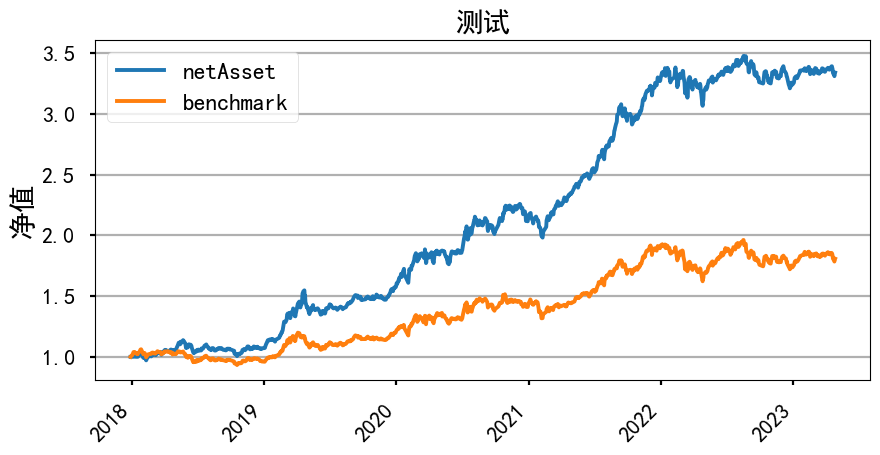

In [84]:
obs.pnl_plot(title='测试',benchmark=index, freq='day')

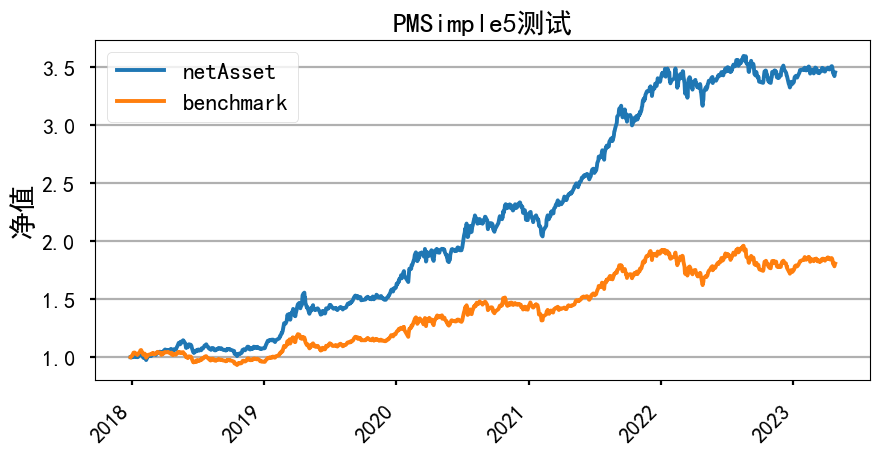

In [85]:
obs_5.pnl_plot(title='PMSimple5测试',benchmark=index, freq='day')

#### 换手率

In [86]:
t_start = date_weekend
t_end = date_weekend + pd.offsets.Day(7+2)
[*zip(t_start, t_end)][:5]

[(Timestamp('2017-01-01 00:00:00', freq='W-SUN'),
  Timestamp('2017-01-10 00:00:00')),
 (Timestamp('2017-01-08 00:00:00', freq='W-SUN'),
  Timestamp('2017-01-17 00:00:00')),
 (Timestamp('2017-01-15 00:00:00', freq='W-SUN'),
  Timestamp('2017-01-24 00:00:00')),
 (Timestamp('2017-01-22 00:00:00', freq='W-SUN'),
  Timestamp('2017-01-31 00:00:00')),
 (Timestamp('2017-01-29 00:00:00', freq='W-SUN'),
  Timestamp('2017-02-07 00:00:00'))]

In [87]:
hsl = []
for t_s, t_e in zip(t_start, t_end):
    res = obs.cal_hsl(t_s, t_e)
    if res is not None:
        res['date'] = t_e
        hsl += [res]
hsl = pd.DataFrame(hsl).set_index('date')
hsl.tail()

,start_record_time,end_record_time,nav_end,nav_start,trade_amount,trade_cost,hsl
date,,,,,,,
2023-04-04,2023-03-27 20:00:00,2023-04-03 20:00:00,3.366831e+08,3.364115e+08,1.982913e+08,297441.058341,0.295038
2023-04-11,2023-04-03 20:00:00,2023-04-10 20:00:00,3.368568e+08,3.366831e+08,1.948346e+08,299179.879531,0.289714
2023-04-18,2023-04-10 20:00:00,2023-04-17 20:00:00,3.390212e+08,3.368568e+08,2.158608e+08,323116.678808,0.319856
2023-04-25,2023-04-17 20:00:00,2023-04-24 20:00:00,3.319366e+08,3.390212e+08,2.249766e+08,331688.497533,0.335801
2023-05-02,2023-04-24 20:00:00,2023-04-28 20:00:00,3.358068e+08,3.319366e+08,2.632384e+08,396472.255101,0.394815


<Axes: >

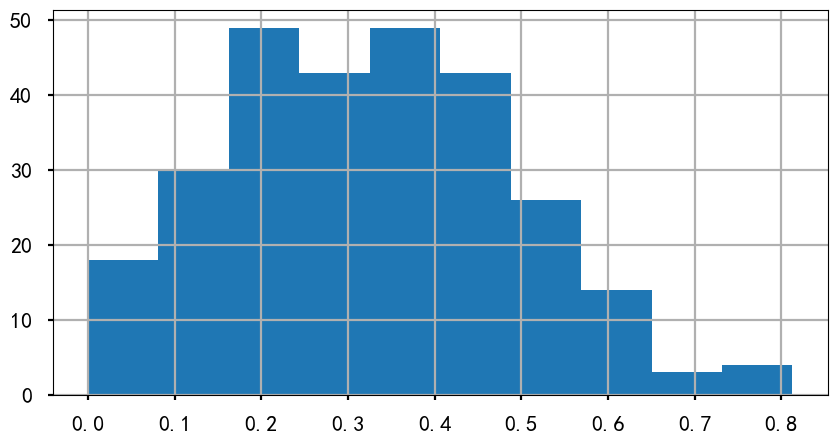

In [88]:
hsl['hsl'].hist(figsize=(10, 5))

<Axes: xlabel='date'>

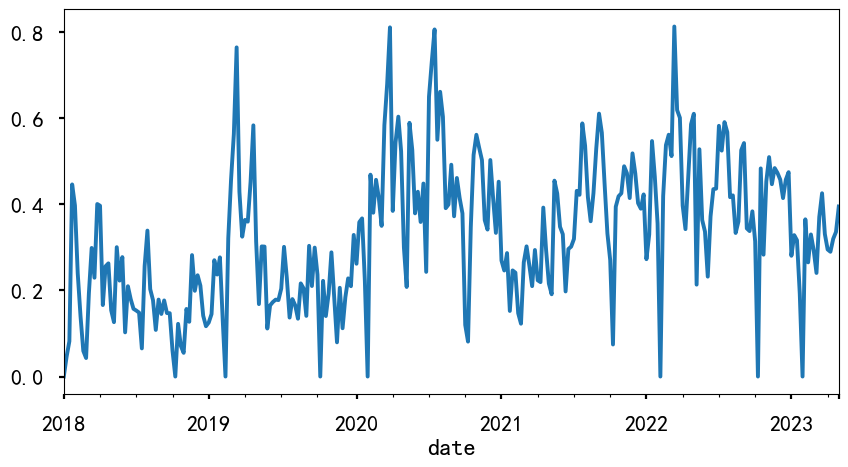

In [89]:
hsl['hsl'].plot(figsize=(10, 5))

In [90]:
ts.pm.get_mkt_data().tail(50).to_excel("数据样例.xlsx")

In [91]:
fct.tail(50).to_excel("信号样例.xlsx")

In [92]:
index.to_excel("指数数据.xlsx")